In [64]:
import pandas as pd
import numpy as np
import yaml
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from scipy.fft import fft
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler, PowerTransformer, RobustScaler
import openpyxl
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score,precision_score, f1_score, mean_squared_error
import optuna
import talib
import json
import pickle
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

In [2]:
def load_yaml(file):
    import yaml
    with open(file, 'r') as f:
        config = yaml.safe_load(f)
    return config

In [11]:
config = load_yaml('../config_bTransformer.yaml')

In [4]:
all_trading_data_dfs = []
sheet_names = ['5minData11-6-2014', '5minData12-17-2019']
for sheet in sheet_names:
    temp_df = pd.read_excel(config['all_data_excel_path'], sheet_name=sheet)
    all_trading_data_dfs.append(temp_df)
all_trading_data = pd.concat(all_trading_data_dfs, ignore_index=True)

# Load 5 min data
all_trading_data['Date'] = pd.to_datetime(all_trading_data['Date'])

In [ ]:
##### Set the Date Start and End for the filtering of trading data
train_start_date = pd.to_datetime('2023-01-01')
train_end_date = pd.to_datetime('2023-05-31')
trading_data_raw = all_trading_data[(all_trading_data['Date'] >= train_start_date) & (all_trading_data['Date'] <= train_end_date)]
trading_data_raw = trading_data_raw.reset_index(drop=True)
trading_data_raw.drop(columns=['Symbol'], inplace=True)
trading_data_raw.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7956 entries, 0 to 7955
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    7956 non-null   datetime64[ns]
 1   Open    7956 non-null   float64       
 2   High    7956 non-null   float64       
 3   Low     7956 non-null   float64       
 4   Close   7956 non-null   float64       
 5   Volume  7956 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 373.1 KB


In [6]:
#### Setting some global variables
n_bars = config['n_past']
m_bars = config['m_future']
fourier_lookback_window = config['fourier_lookback_window']
fourier_n_components = config['fourier_n_components']

In [7]:
def calculate_bollinger_bands(data, window_size, num_std_dev):
    rolling_mean = data['Close'].rolling(window=window_size).mean()
    rolling_std = data['Close'].rolling(window=window_size).std()
    data['BOLLBU'] = rolling_mean + (rolling_std * num_std_dev)
    data['BOLLBM'] = rolling_mean
    data['BOLLBL'] = rolling_mean - (rolling_std * num_std_dev)
    
    return data

def calculate_donchn_bands(data, window_size):
    data['DONCH_U'] = data['High'].rolling(window=window_size).max()
    data['DONCH_L'] = data['Low'].rolling(window=window_size).min()
    
    return data
    
def calculate_tchr(data):
    period = config['tchr_period']
    retracement = config['tchr_retracement']
    adj = config['tchr_adj']
    range = config['tchr_range']

    if range == 'highlow':
        data['TCHR_U'] = talib.MAX(data['High'], timeperiod=period) + adj
        data['TCHR_L'] = talib.MIN(data['Low'], timeperiod=period) - adj
    elif range == 'close':
        data['TCHR_U'] = talib.MAX(data['Close'], timeperiod=period) + adj
        data['TCHR_L'] = talib.MIN(data['Close'], timeperiod=period) - adj
    
    #calculate retracement
    if retracement == "long":
        data['TCHR'] = (data['Close'] - data['TCHR_L']) / (data['TCHR_U'] - data['TCHR_L'])
    elif retracement == "short":
        data['TCHR'] = (data['TCHR_U'] - data['Close']) / (data['TCHR_U'] - data['TCHR_L'])
    
    return data
    
def calculate_adwm(data):
    period = config['adwm_period']
    data['Previous_Close']= data['Close'].shift(1)
    data['TRH'] = data[['High', 'Previous_Close']].max(axis=1)
    data['TRL'] = data[['Low', 'Previous_Close']].min(axis=1)

    data['ADWM_AD'] = 0.0
    data.loc[data['Close'] > data['Previous_Close'], 'ADWM_AD'] = (data['Close'] - data['TRL'])
    data.loc[data['Close'] < data['Previous_Close'], 'ADWM_AD'] = (data['Close'] - data['TRH'])

    data['ADWM'] = data['ADWM_AD']

    data['ADWMMA'] = data['ADWM'].rolling(window=period).mean()

    return data

def calculate_si(row, prev_row, limit):
    if pd.isna(prev_row['Close']):
        return 0
    c = row['Close']
    c_prev = prev_row['Close']
    o = row['Open']
    o_prev = prev_row['Open']
    return (50 * ((c - c_prev) + (0.5 * (c - o)) + (0.25 * (c_prev - o_prev))) / limit)

def calculate_WASI(data):
    wasi_limit = config['wasi_limit']
    data['SI'] = data.apply(lambda row: calculate_si(row, data.shift(1).loc[row.name], wasi_limit), axis=1)
    data['WASI'] = data['SI']
    return data

def calculate_ATR(data):
    atr_period = config['atr_period']
    atr_ma = config['atr_ma']
    data['ATR'] = talib.ATR(data['High'], data['Low'], data['Close'], timeperiod=atr_period)
    data['ADJATR'] = talib.SMA(data['ATR'], timeperiod=atr_ma)
    return data


def compute_fourier_df(value_series, n_components=10):
    fft_result = np.fft.fft(value_series)
    real = fft_result.real[:n_components]
    imag = fft_result.imag[:n_components]
    mag = np.abs(fft_result)[:n_components]

    return real, imag, mag

def get_fourier_columns():
    return [f'fourier_real_{j+2}' for j in range(fourier_n_components-1)] + [f'fourier_imag_{j+2}' for j in range(fourier_n_components-1)] + [f'fourier_mag_{j+2}' for j in range(fourier_n_components-1)]   
    

In [27]:
def add_new_features_df(data):
    fourier_lookback_window = config['fourier_lookback_window']
    fourier_n_components = config['fourier_n_components']

    #data['Date'] = pd.to_datetime(data['Date'])
    #print(f"bolband period : {config['bolband_period']}")
    bolband_period = config['bolband_period']
    bolband_width = config['bolband_width']
    upper, middle, lower = talib.BBANDS(data['Close'], timeperiod=bolband_period, nbdevup=bolband_width, nbdevdn=bolband_width, matype=0)
    data['BOLLBU'] = upper
    data['BOLLBM'] = middle
    data['BOLLBL'] = lower
    #data = calculate_bollinger_bands(data, int(config['bolband_period']), int(config['bolband_width']))

    # Calculate DONCHN Bands
    donchn_period = config['donchn_period']
    data['DONUP'] = talib.MAX(data['High'], timeperiod=donchn_period)

    data['DONLOW'] = talib.MIN(data['Low'], timeperiod=donchn_period)

    data['DONMID'] = (data['DONLOW'] + data['DONUP']) / 2

    data['MA20'] = talib.SMA(data['Close'], timeperiod=20)

    data['MA50'] = talib.SMA(data['Close'], timeperiod=50)

    data['MA100'] = talib.SMA(data['Close'], timeperiod=100)

    data['EMA20'] = talib.EMA(data['Close'], timeperiod=20)

    # Calculate the pivot points
    data['PVPT'] = (data['High'] + data['Low'] + data['Close']) / 3
    data['PVPTR1'] = (2 * data['PVPT']) - data['Low']

    data['PVPTR2'] = data['PVPT'] + data['High'] - data['Low']

    data['PVPTR3'] = data['High'] + 2 * (data['PVPT'] - data['Low'])

    data['PVPTS1'] = (2 * data['PVPT']) - data['High']

    data['PVPTS2'] = data['PVPT'] - (data['High'] - data['Low'])

    data['PVPTS3'] = data['Low'] - 2 * (data['High'] - data['PVPT'])

    data = calculate_tchr(data)

    data = calculate_adwm(data)

    data = calculate_WASI(data)

    volume_ma_period = config['volume_ma_period']

    data['VOLMA'] = talib.SMA(data['Volume'], timeperiod=volume_ma_period)

    data = calculate_ATR(data)

    data['DayofWeek'] = data['Date'].dt.dayofweek

    data['DayofWeek'] = data['DayofWeek'].astype('category')

    # Add fourier columns to the df
    for i in range(fourier_n_components):
        data[f'fourier_real_{i+1}'] = np.nan
        data[f'fourier_imag_{i+1}'] = np.nan
        data[f'fourier_mag_{i+1}'] = np.nan

    features = []
    epsilon = 1e-5
    #print(f"fourier window - 1 : {fourier_lookback_window - 1}")
    for i in range(len(data)):
        if i >= fourier_lookback_window - 1:
            #print("entered point 1")
            close_window = data['Close'].iloc[i - fourier_lookback_window + 1: i + 1].values
            real, imag, mag = compute_fourier_df(close_window, n_components=fourier_n_components)

            for j in range(fourier_n_components):
                data.iloc[i, data.columns.get_loc(f'fourier_real_{j+1}')] = real[j]
                data.iloc[i, data.columns.get_loc(f'fourier_imag_{j+1}')] = imag[j]
                data.iloc[i, data.columns.get_loc(f'fourier_mag_{j+1}')] = mag[j]
                #print(data.loc[i, 'Date'])
    


    # Add the time of day feature to the trading data

    # Define max time of day in minutes
    MAX_TIME_MINUTES = 1440
    data['Minutes_Passed'] = (data['Date'].dt.hour* 60) + data['Date'].dt.minute
    print(f"number of na s : {data['Date'].isna().sum()}")
    data['TimeOfDay_Group'] = (data['Minutes_Passed'] // 5).astype('int')
    data['Sine_TimeOfDay'] = np.sin(2 * np.pi * data['TimeOfDay_Group'] / MAX_TIME_MINUTES)
    data['Cosine_TimeOfDay'] = np.cos(2 * np.pi * data['TimeOfDay_Group'] / MAX_TIME_MINUTES)
    data['Take_Profit_Level'] = (data['Close'] * config['atr_multiplier'] * data['ADJATR'])
    #print(f"Last row after adding features : ")
    #print(data.tail())
    return data


#### Adding additional features

In [28]:
trading_data_with_features = add_new_features_df(trading_data_raw.copy())
trading_data_with_features = trading_data_with_features.dropna()
trading_data_with_features.reset_index(drop=True, inplace=True)

number of na s : 0


In [29]:
pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.max_rows", None)  # Show all rows
trading_data_with_features.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,7857,2023-03-18 11:12:09.553264384,2023-01-04 11:15:00,2023-02-09 12:25:00,2023-03-17 13:35:00,2023-04-24 14:45:00,2023-05-30 15:55:00,NaN
Open,7857.0,404.272218,378.91,397.22,406.57,411.72,422.41,9.278706
High,7857.0,404.536566,379.22,397.436,406.81,411.91,422.58,9.231512
Low,7857.0,404.01024,378.76,396.95,406.34,411.48,421.91,9.319458
Close,7857.0,404.277669,378.9097,397.215,406.57,411.725,422.4,9.277785
Volume,7857.0,785899.957108,136615.0,417842.0,597697.0,882109.0,14680996.0,777392.46488
BOLLBU,7857.0,405.500294,380.091158,398.508695,407.578116,412.676441,422.335445,9.107833
BOLLBM,7857.0,404.231759,379.543685,397.21594,406.57562,411.691595,421.132395,9.260963
BOLLBL,7857.0,402.963224,377.780783,395.833517,405.295362,410.721785,420.184965,9.49077
DONUP,7857.0,405.537741,380.34,398.485,407.53,412.76,422.58,9.075343


In [30]:
def transform_features(df):
    close_diff_features = config['Close_Diff_Features'].split(',')
    df[close_diff_features] = df[close_diff_features].sub(df['Close'], axis=0)
    return df


In [31]:
trading_data_transformed = transform_features(trading_data_with_features.copy())

In [32]:
close_diff_features = config['Close_Diff_Features'].split(',')

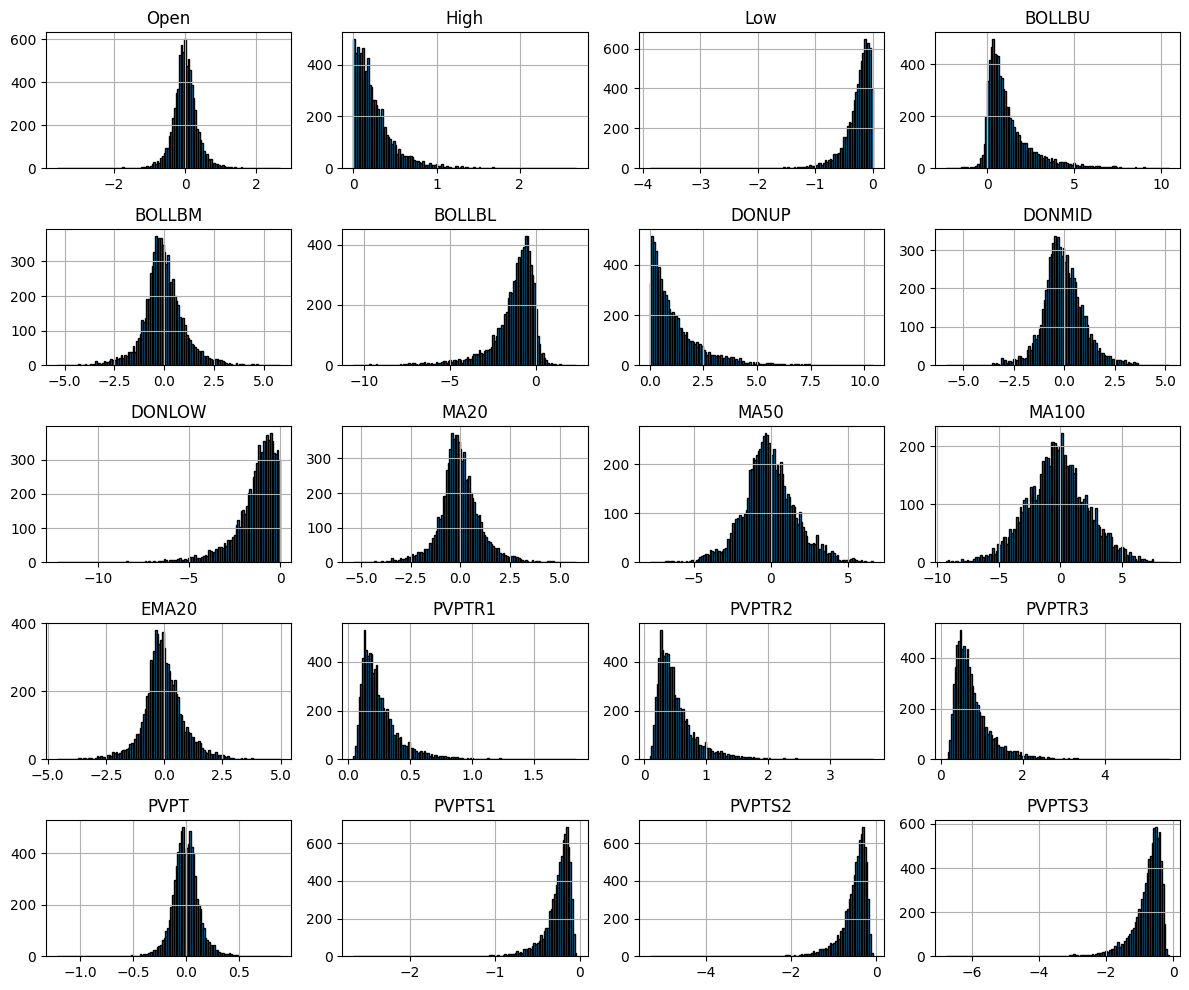

In [33]:
trading_data_transformed[close_diff_features].hist(figsize=(12,10), bins=130, edgecolor='black')
plt.tight_layout()
plt.show()

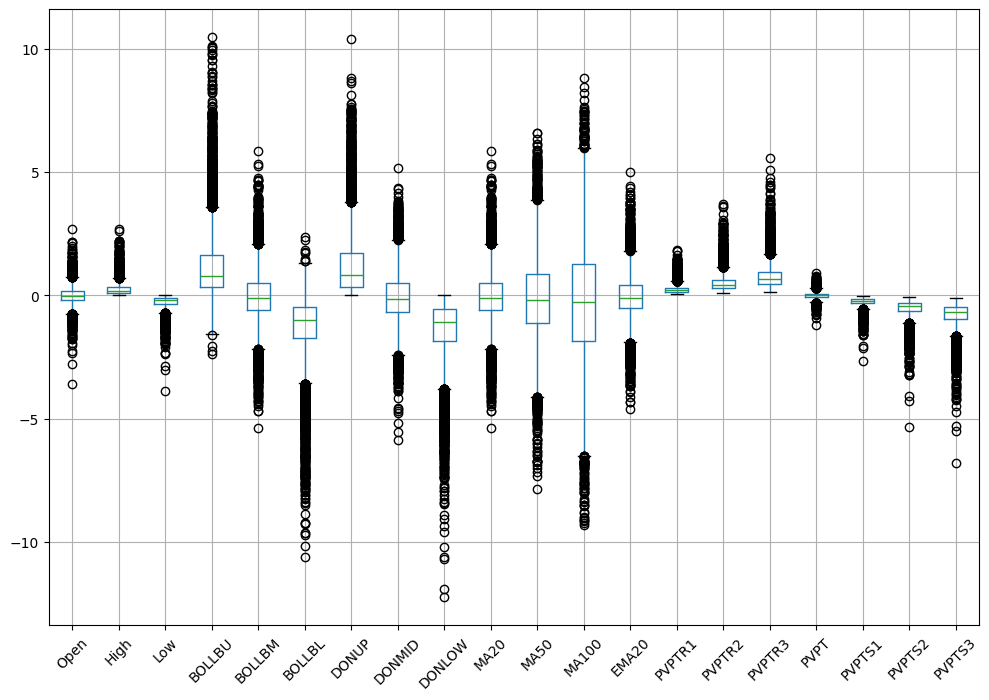

In [34]:
### Show box plots for all features g1
plt.figure(figsize=(12,8))
trading_data_transformed[close_diff_features].boxplot(rot=45)
plt.show()

In [35]:
rscaler = RobustScaler()
trading_data_robust_scaled = trading_data_transformed.copy()
trading_data_robust_scaled[close_diff_features] = rscaler.fit_transform(trading_data_transformed[close_diff_features])

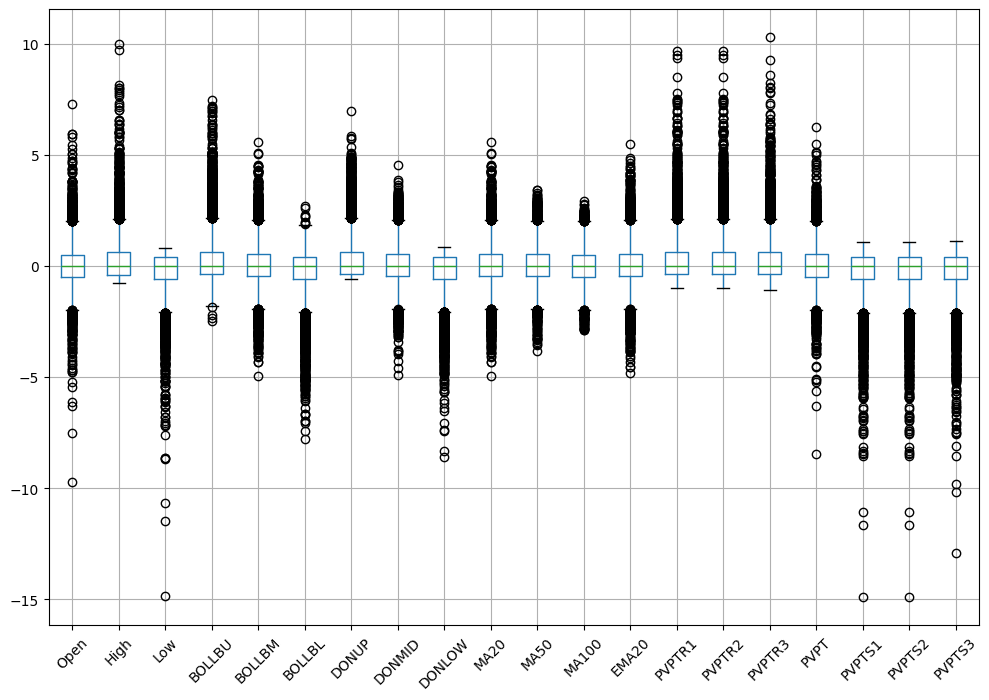

In [36]:
### Show box plots for all features robust scaled
plt.figure(figsize=(12,8))
trading_data_robust_scaled[close_diff_features].boxplot(rot=45)
plt.show()

In [37]:
trading_data_log_transformed = trading_data_transformed.copy()
trading_data_log_transformed[close_diff_features] = np.log1p(np.abs(trading_data_transformed[close_diff_features])) * np.sign(trading_data_transformed[close_diff_features]) 

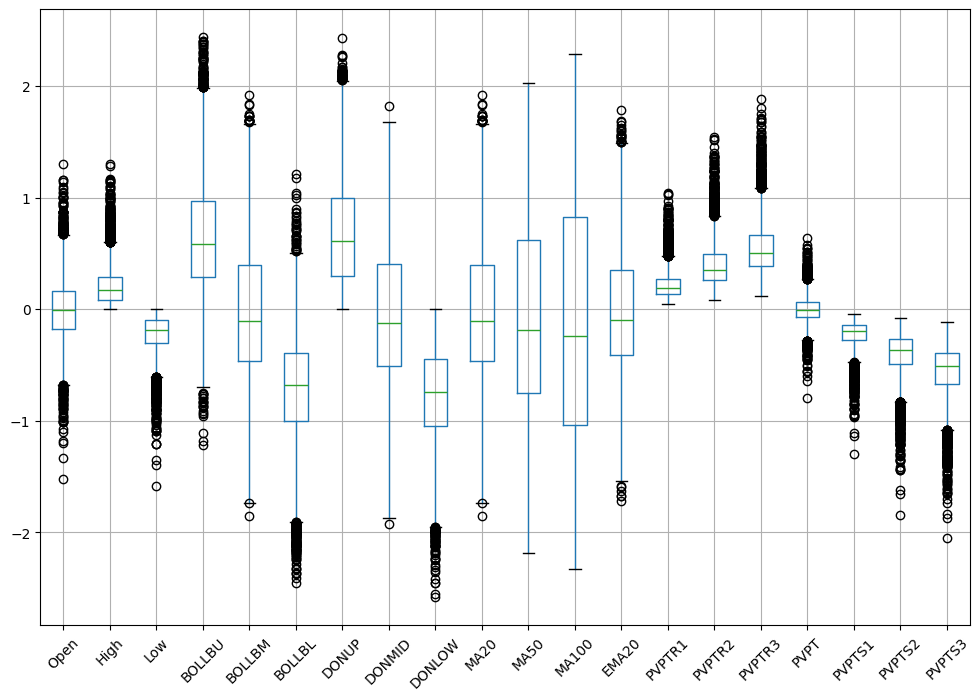

In [38]:
### Show box plots for all features Log transformed
plt.figure(figsize=(12,8))
trading_data_log_transformed[close_diff_features].boxplot(rot=45)
plt.show()

In [39]:
#### Robust scale log transformed
trading_data_robust_scaled_log = trading_data_log_transformed.copy()
trading_data_robust_scaled_log[close_diff_features] = rscaler.fit_transform(trading_data_log_transformed[close_diff_features])

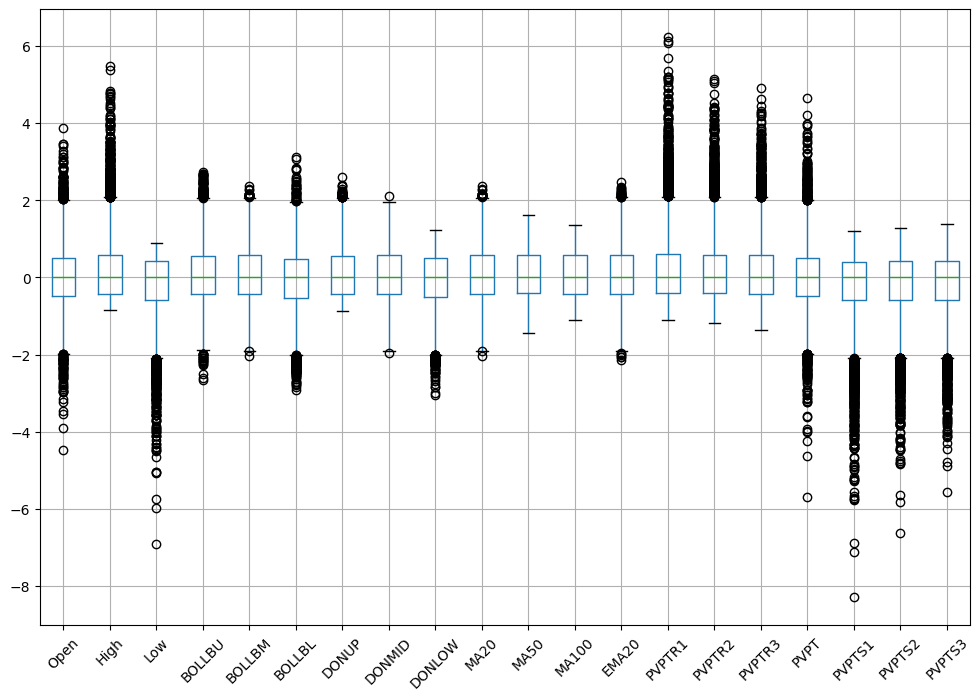

In [40]:
### Show box plots for all features Log transformed robust scaled
plt.figure(figsize=(12,8))
trading_data_robust_scaled_log[close_diff_features].boxplot(rot=45)
plt.show()

In [49]:
volume_features = ['Volume', 'VOLMA']

In [53]:
trading_data_volume_log_transformed = trading_data_transformed.copy()
trading_data_volume_log_transformed[volume_features] = np.log1p(np.abs(trading_data_transformed[volume_features])) * np.sign(trading_data_transformed[volume_features])
rscaler_volume = RobustScaler()
trading_data_volume_log_transformed[volume_features] = rscaler_volume.fit_transform(trading_data_volume_log_transformed[volume_features])

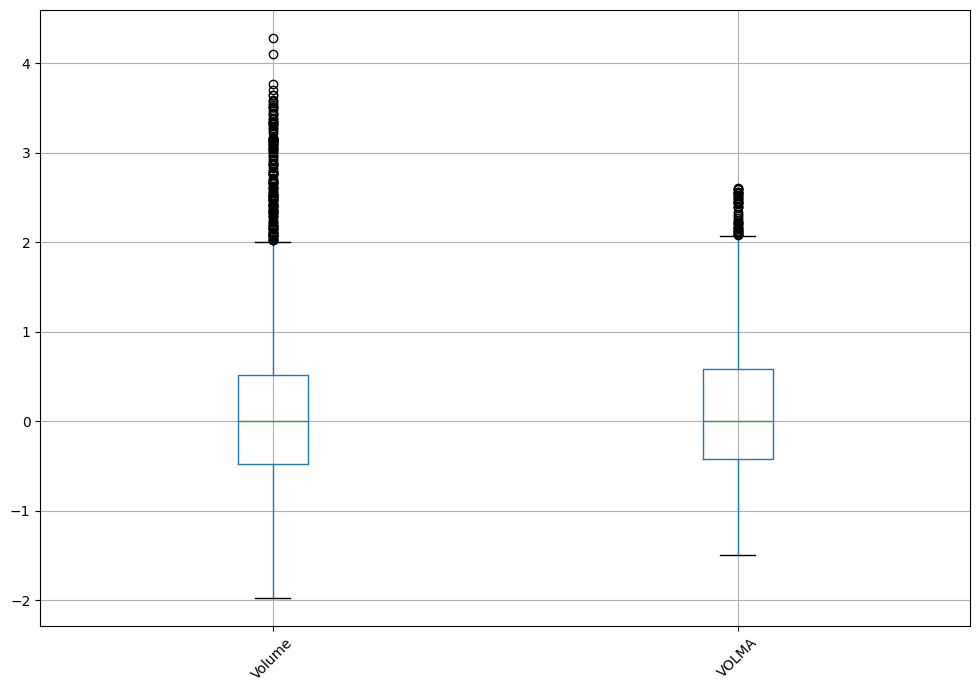

In [54]:
### Show box plots for volume
plt.figure(figsize=(12,8))
trading_data_volume_log_transformed[volume_features].boxplot(rot=45)
plt.show()

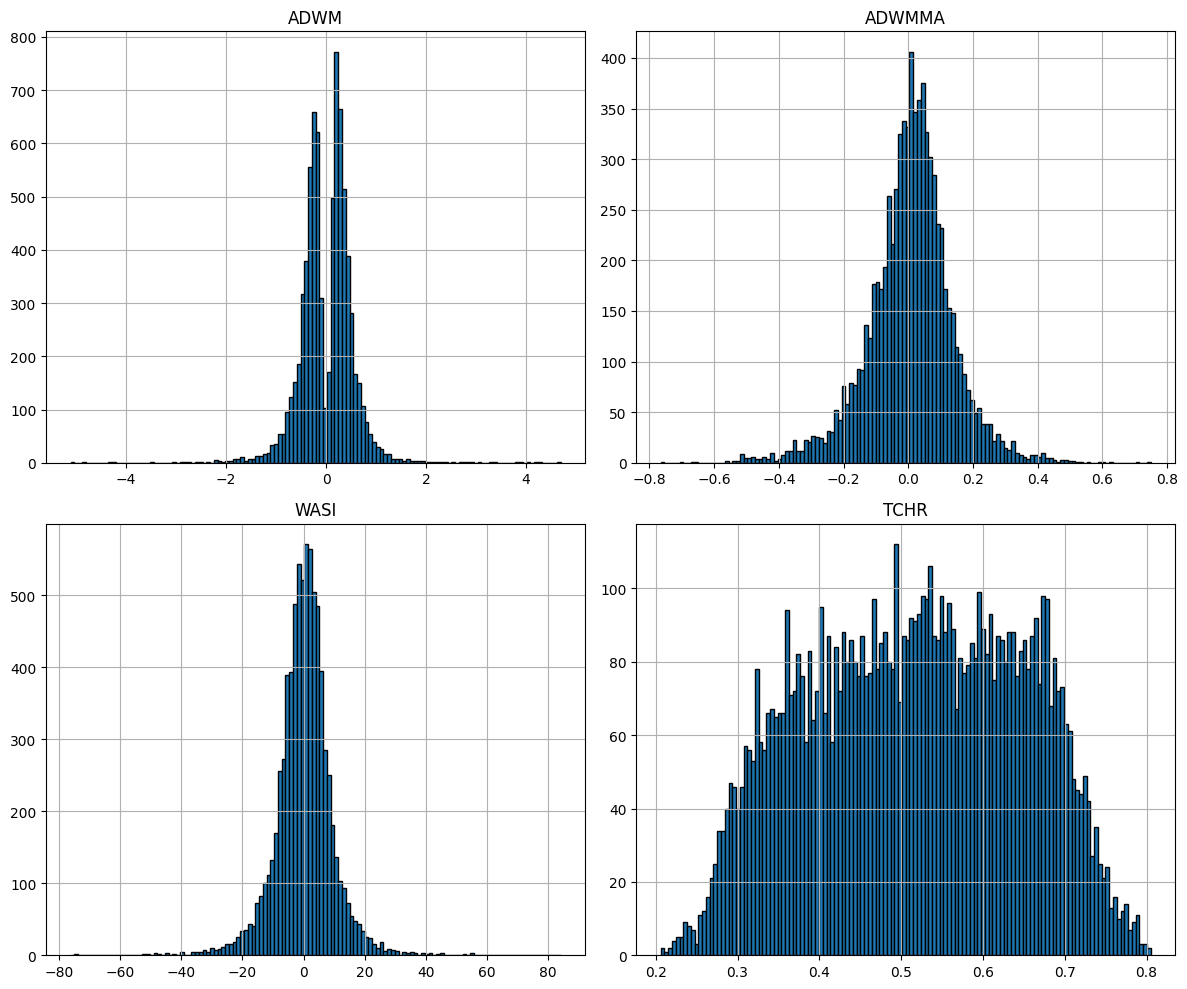

In [46]:
other_features = ['ADWM', 'ADWMMA', 'WASI', 'TCHR']
trading_data_transformed[other_features].hist(figsize=(12,10), bins=130, edgecolor='black')
plt.tight_layout()
plt.show()

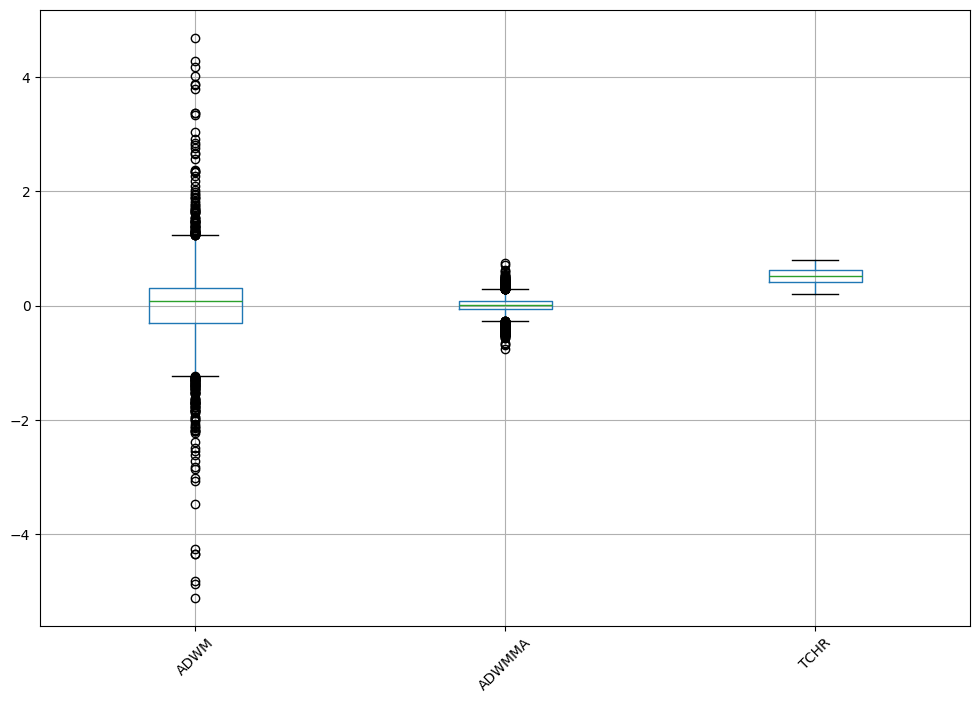

In [48]:
### Show box plots for other features
plt.figure(figsize=(12,8))
trading_data_transformed[['ADWM', 'ADWMMA', 'TCHR']].boxplot(rot=45)
plt.show()

In [ ]:
trading_data_vol_log_transformed = trading_data_transformed.copy()
trading_data_vol_log_transformed[close_diff_features] = np.log1p(np.abs(trading_data_transformed[close_diff_features])) * np.sign(trading_data_transformed[close_diff_features]) 

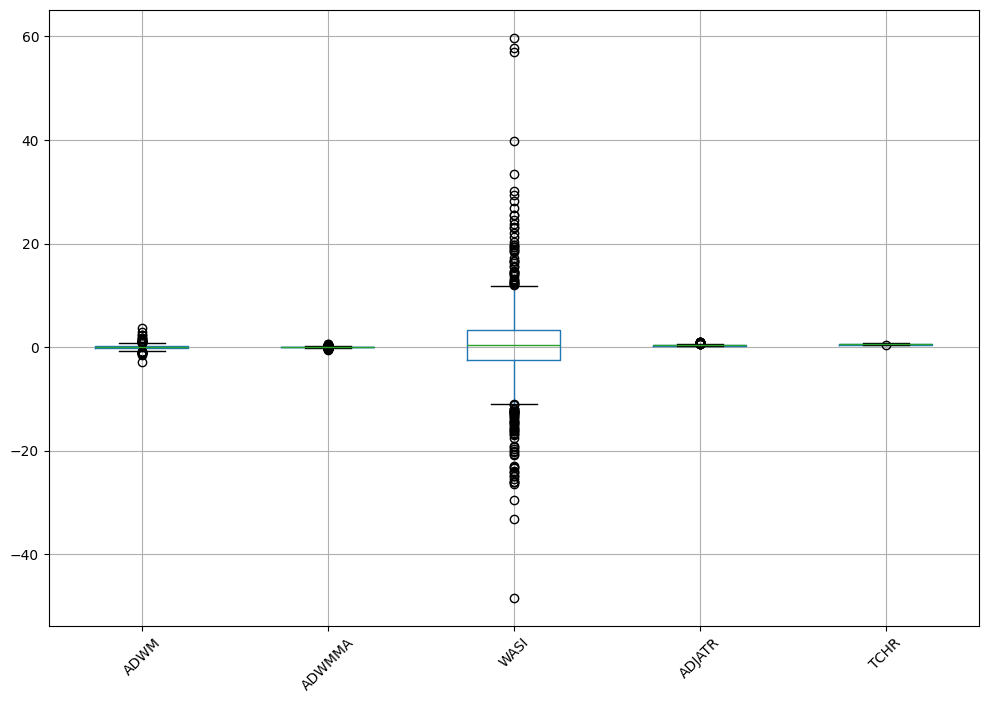

In [ ]:
### Show box plots for all features g2
plt.figure(figsize=(12,8))
trading_data[raw_features_g2].boxplot(rot=45)
#trading_data[['ADWM', 'ADWMMA', 'ADJATR', 'TCHR']].boxplot(rot=45)
plt.show()

array([[<Axes: title={'center': 'fourier_real_2'}>,
        <Axes: title={'center': 'fourier_real_3'}>,
        <Axes: title={'center': 'fourier_real_4'}>,
        <Axes: title={'center': 'fourier_real_5'}>,
        <Axes: title={'center': 'fourier_real_6'}>],
       [<Axes: title={'center': 'fourier_real_7'}>,
        <Axes: title={'center': 'fourier_real_8'}>,
        <Axes: title={'center': 'fourier_real_9'}>,
        <Axes: title={'center': 'fourier_real_10'}>,
        <Axes: title={'center': 'fourier_imag_2'}>],
       [<Axes: title={'center': 'fourier_imag_3'}>,
        <Axes: title={'center': 'fourier_imag_4'}>,
        <Axes: title={'center': 'fourier_imag_5'}>,
        <Axes: title={'center': 'fourier_imag_6'}>,
        <Axes: title={'center': 'fourier_imag_7'}>],
       [<Axes: title={'center': 'fourier_imag_8'}>,
        <Axes: title={'center': 'fourier_imag_9'}>,
        <Axes: title={'center': 'fourier_imag_10'}>,
        <Axes: title={'center': 'fourier_mag_2'}>,
        

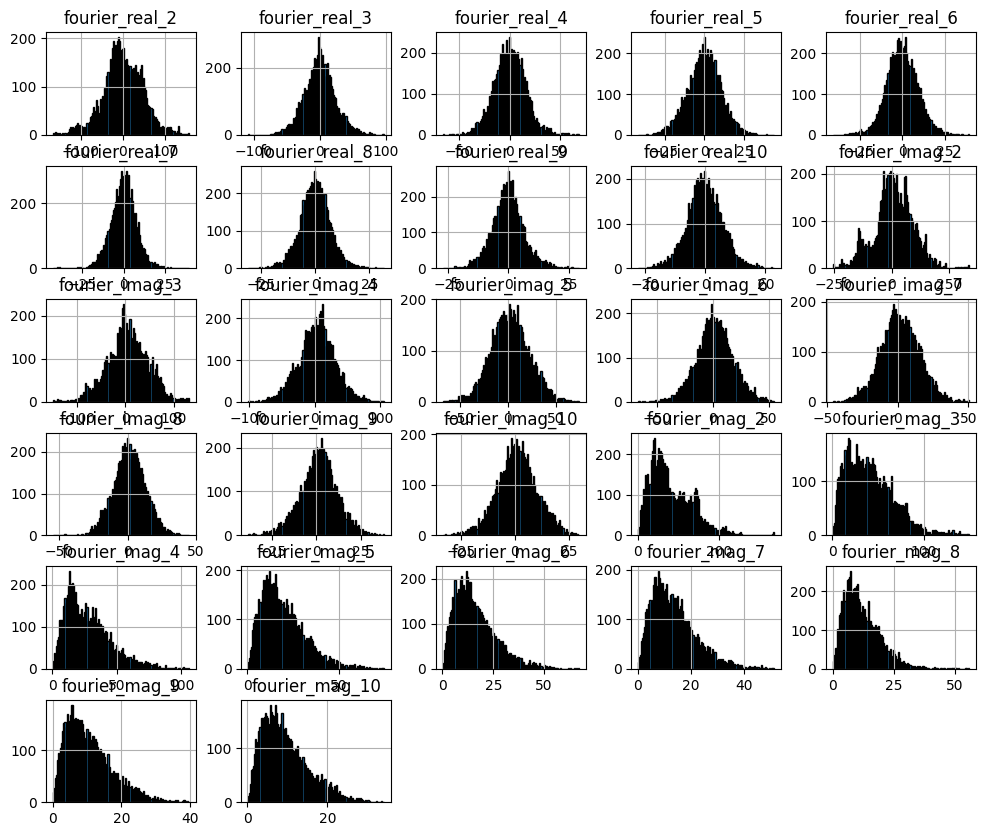

In [55]:
fourier_cols = get_fourier_columns()
trading_data_transformed[fourier_cols].hist(figsize=(12,10), bins=130, edgecolor='black')

In [56]:
time_cols = ['Sine_TimeOfDay', 'Cosine_TimeOfDay']

In [57]:
all_features = close_diff_features + volume_features + other_features + fourier_cols + time_cols

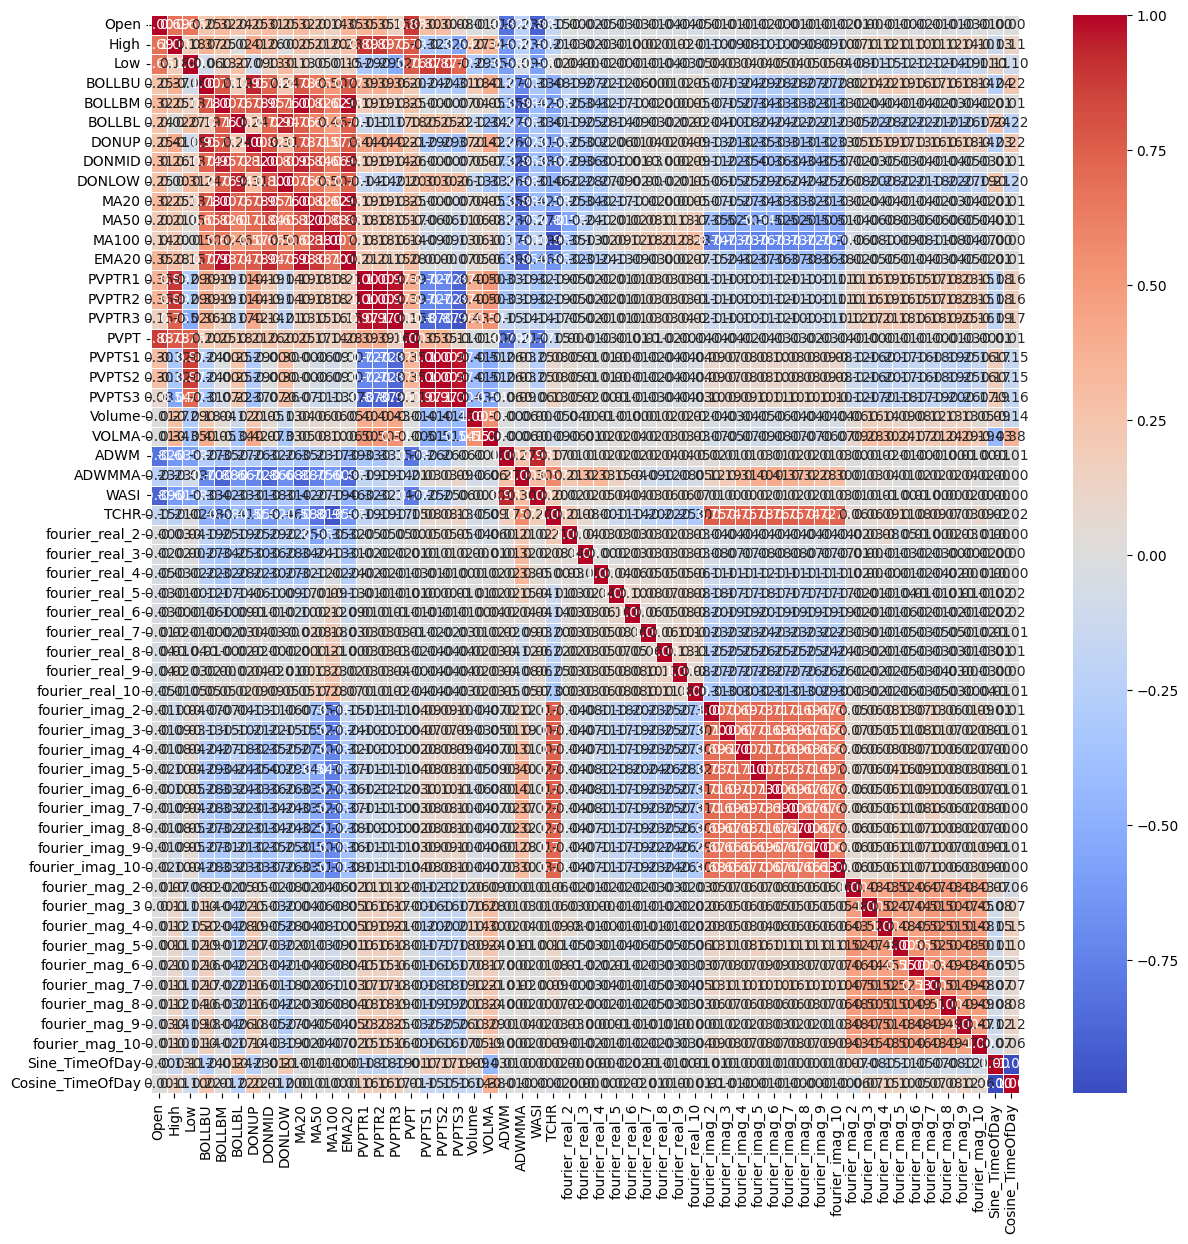

In [62]:
plt.figure(figsize=(14,14))
sns.heatmap(trading_data_transformed[all_features].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.show()

#### Check Features importance

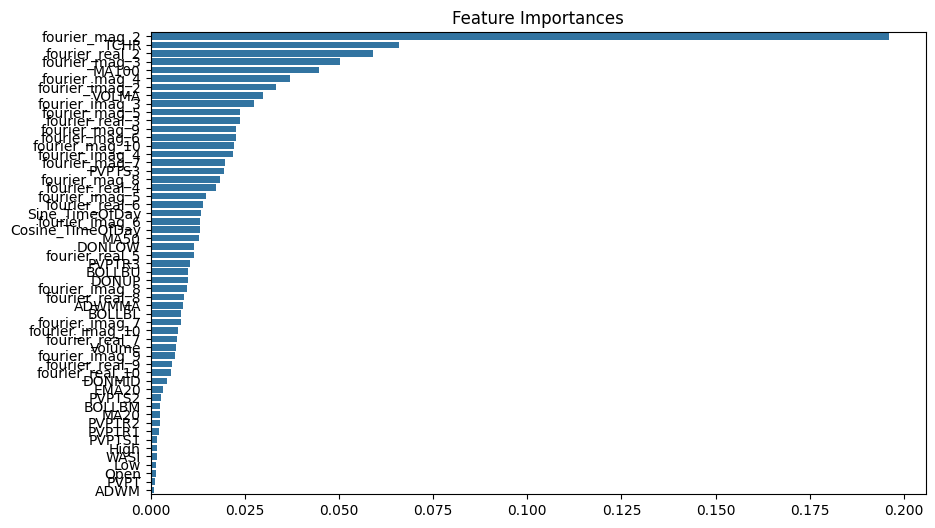

In [ ]:
X = trading_data_transformed[all_features].copy()
rscaler = RobustScaler()
X[all_features] = rscaler.fit_transform(X[all_features])
y = trading_data_with_features['Close']

model = RandomForestRegressor(n_estimators=100)
model.fit(X,y)

importances = model.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
feature_names = X.columns



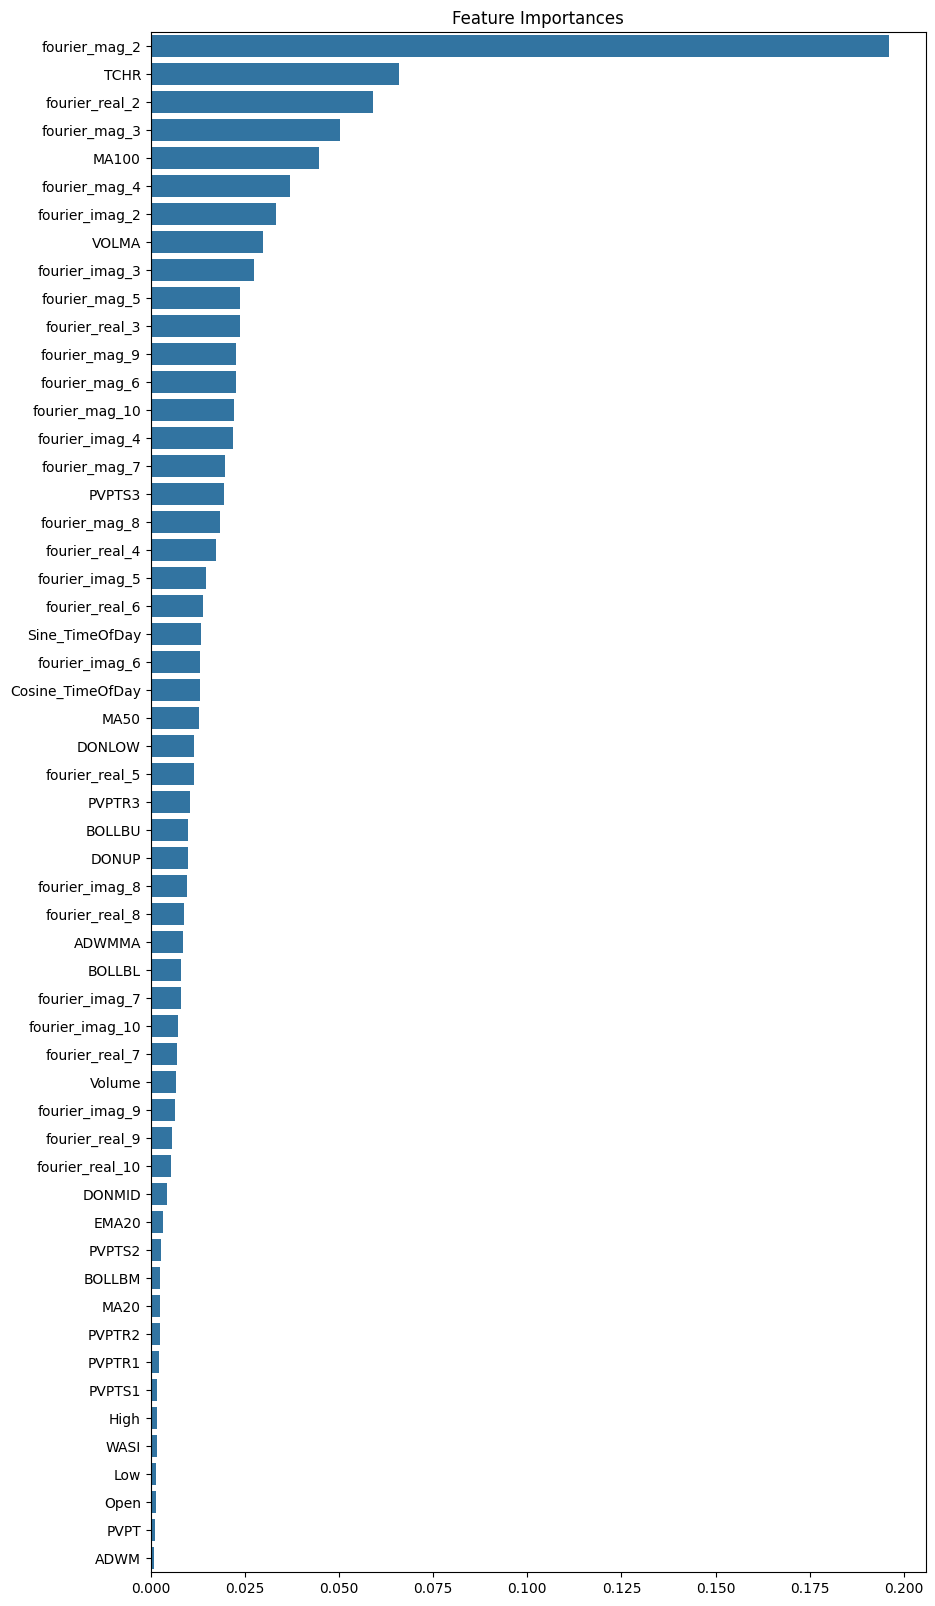

In [70]:
plt.figure(figsize=(10,20))
sns.barplot(x=importances[sorted_indices], y=np.array(all_features)[sorted_indices])
plt.title("Feature Importances")
plt.show()